In [12]:
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.util import ngrams
nltk.download('punkt_tab')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# Load dataset
df = pd.read_csv('amazon reviews dataset.csv')

# Drop unnecessary columns
df = df[['reviews.text', 'reviews.rating']].dropna()

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['reviews.text'].apply(preprocess_text)

# Convert ratings to sentiment labels
def assign_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['reviews.rating'].apply(assign_sentiment)

<ipython-input-4-e0fa3a871ff8>:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('amazon reviews dataset.csv')


In [5]:
print("Original Distribution of Sentiment:", Counter(df['sentiment']))

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment']
)

# TF-IDF Vectorization
vectorizer_tdif = TfidfVectorizer(max_features=10_000, ngram_range=(1,2))
tfidf_X = vectorizer_tdif.fit_transform(X_train)
tfidf_X_test = vectorizer_tdif.transform(X_test)

# Handle class imbalance
oversampling = SMOTE(sampling_strategy='auto', random_state=42)
tfidf_X, y_train = oversampling.fit_resample(tfidf_X, y_train)

print("Resampled Distribution of Sentiment after SMOTE:", Counter(y_train))

# Train Logistic Regression
model_logistic_regression = LogisticRegression(class_weight='balanced', max_iter=1000)
model_logistic_regression.fit(tfidf_X, y_train)

# Predict with Logistic Regression
logistic_regression_pred = model_logistic_regression.predict(tfidf_X_test)

# Evaluate Logistic Regression
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, logistic_regression_pred):.4f}")
print("Logistic Regression Classification Report:\n", classification_report(y_test, logistic_regression_pred))

Original Distribution of Sentiment: Counter({'positive': 32315, 'neutral': 1499, 'negative': 812})
Resampled Distribution of Sentiment after SMOTE: Counter({'positive': 25851, 'neutral': 25851, 'negative': 25851})
Logistic Regression Accuracy: 0.8781
Logistic Regression Classification Report:
               precision    recall  f1-score   support

    negative       0.30      0.59      0.40       162
     neutral       0.19      0.35      0.25       300
    positive       0.97      0.91      0.94      6464

    accuracy                           0.88      6926
   macro avg       0.49      0.62      0.53      6926
weighted avg       0.92      0.88      0.90      6926



In [6]:
# Train Naïve Bayes
model_naive_bayes = MultinomialNB()
model_naive_bayes.fit(tfidf_X, y_train)

# Predict with Naïve Bayes
naive_bayes_pred = model_naive_bayes.predict(tfidf_X_test)

# Evaluate Naïve Bayes
print(f"Naïve Bayes Accuracy: {accuracy_score(y_test, naive_bayes_pred):.4f}")
print("Naïve Bayes Classification Report:\n", classification_report(y_test, naive_bayes_pred))

Naïve Bayes Accuracy: 0.8301
Naïve Bayes Classification Report:
               precision    recall  f1-score   support

    negative       0.24      0.59      0.34       162
     neutral       0.16      0.50      0.25       300
    positive       0.98      0.85      0.91      6464

    accuracy                           0.83      6926
   macro avg       0.46      0.65      0.50      6926
weighted avg       0.93      0.83      0.87      6926



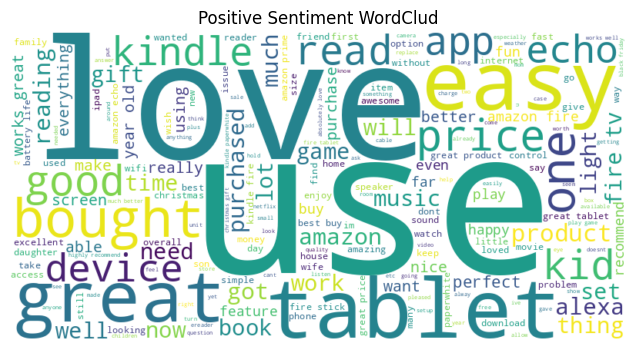

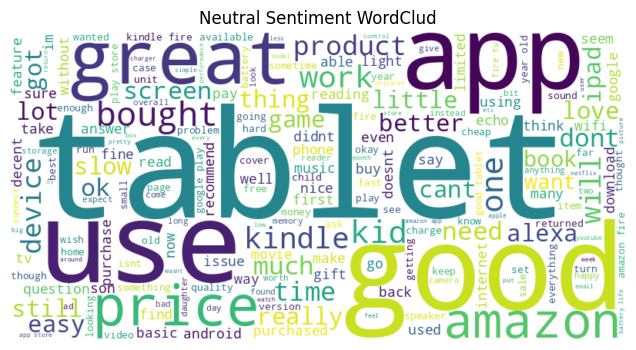

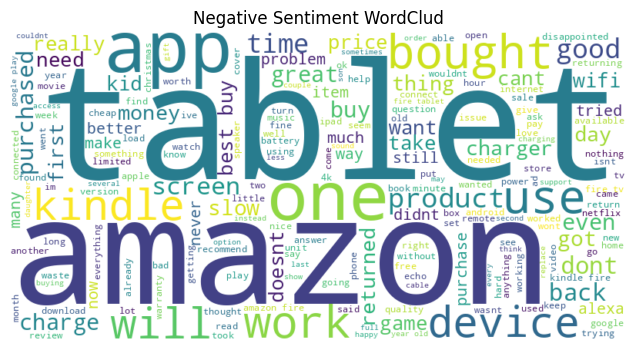

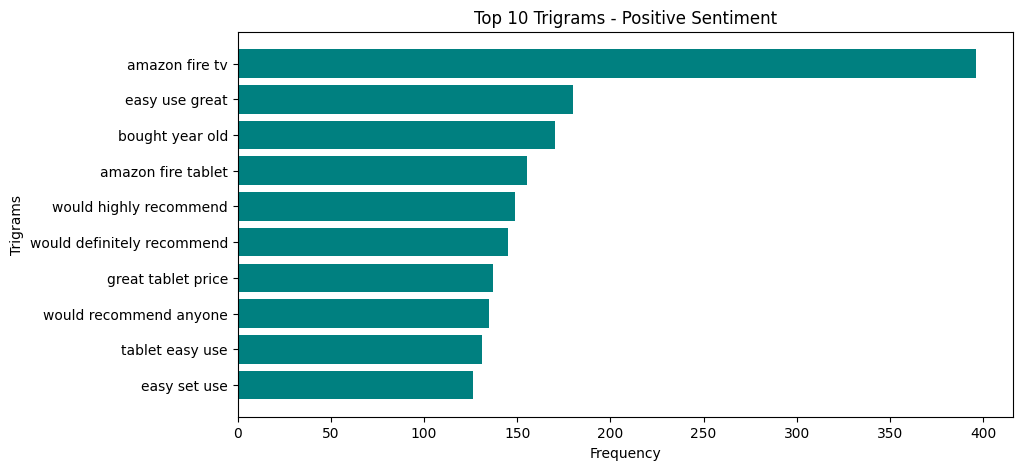

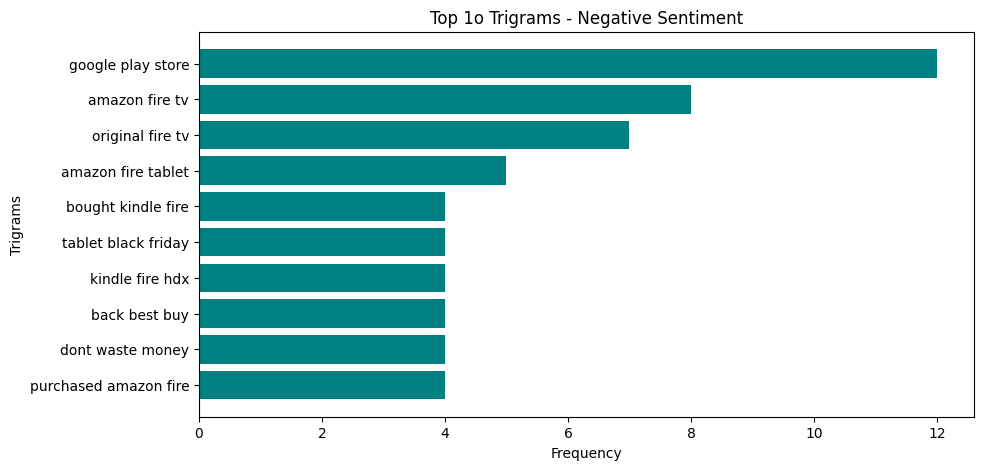

In [13]:
# Word Cloud Visualization
def wordcloud(sentiment):
    words = ' '.join(df[df['sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{sentiment.capitalize()} Sentiment WordClud")
    plt.show()

for sentiment in ['positive', 'neutral', 'negative']:
   wordcloud(sentiment)

# Trigram Extraction
def trigrams(text, n=3):
    tokens = [word for word in nltk.word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]
    return list(ngrams(tokens, n))

text_positive = ' '.join(df[df['sentiment'] == 'positive']['cleaned_text'])
text_negative = ' '.join(df[df['sentiment'] == 'negative']['cleaned_text'])

positive_trigrams = trigrams(text_positive, 3)
negative_trigrams = trigrams(text_negative, 3)

# Count most common trigrams
count_positive_trigram = Counter(positive_trigrams).most_common(10)
count_negative_trigram = Counter(negative_trigrams).most_common(10)

# Plot Trigrams
def plot_trigrams(trigram_counts, title):
    trigrams, counts = zip(*trigram_counts)
    trigrams = [' '.join(tri) for tri in trigrams]

    plt.figure(figsize=(10, 5))
    plt.barh(trigrams, counts, color='teal')
    plt.xlabel("Frequency")
    plt.ylabel("Trigrams")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_trigrams(count_positive_trigram, "Top 10 Trigrams - Positive Sentiment")
plot_trigrams(count_negative_trigram, "Top 1o Trigrams - Negative Sentiment")